In [1]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import numpy
from IPython.display import Image
import matplotlib.pyplot as plt

import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)


 using cli
 using CLI for selections


(None, <pyximport.pyximport.PyxImporter at 0x7fd88d23bf10>)

In [2]:
def equil_values(init_values, primordial, t =3.16e13, niter= 1e5, full_output = False):
    
    
    
    primordial.write_solver("sunny", output_dir = ".",
                            init_values=init_values,
                            input_is_number=False)

    sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")
    rv, rv_int = sunny_solver_run.run_sunny(init_values, t, niter=niter) ;
    
    mask = rv_int['successful']
    
    if full_output:
        return rv_int, 0
    else:
        return rv_int['H_1'][:, mask][:,-1] / init_values['density'], rv_int['t'][mask][-1]

In [3]:
# only two species


def Init_values(temperature, density, fH):
    
    X = 1.0
    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()

    for i in range(23):
        try: 
            if (i+1) not in [3,4,5,6]:
                primordial.add_reaction("k{0:02d}".format(i+1))
        except:
            pass
    
    
    primordial.init_temperature((1e0, 1e5))

    tiny = 1e-20

    # init_array are is in fractional abundances
    init_array = density
    init_values = dict()

    init_values["H_1"]     = density * fH 
    init_values['H_2']     = tiny*density * fH
    init_values["H_m0"]    = tiny*density * fH

    init_values["H2_1"]    = density * (1.0 - fH)
    init_values["H2_2"]    = tiny*density * (1.0 - fH)

    # now everything in mass density
#    init_values = primordial.convert_to_mass_density(init_values)
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)
    number_density = primordial.calculate_number_density(init_values)

    # set up initial temperatures values used to define ge
    init_values['T'] = temperature

    # calculate ge (very crudely, no H2 help here)
    gamma = 5.0/3.0
    init_values['ge'] = ((temperature * number_density * kboltz)
                         / (init_values['density'] * mh * (gamma - 1)))
    return init_values, primordial

In [4]:
def main(fH, temp, den , full_output = False):
    
    
    temp = temp.flatten()
    den = den.flatten()
    
    h_array = numpy.zeros((len(temp), len(den)))
    t_array = numpy.zeros((len(den)))
    
    h_array = []
    t_array = []
    
    print(den)
    for iden, den_arr in enumerate(den):
        
        den_arr = numpy.ones((len(temp)))*den_arr
        
        init_values, primordial = Init_values(temp, den_arr, fH)
        h_array_now, t_array_now = equil_values(init_values, primordial, full_output = full_output)
        
        h_array.append(h_array_now)
        t_array.append(t_array_now)
        
    return h_array, t_array

In [19]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def make_plots( network, init, rv_int, solver_name = 'sundials', t_min = 1e0, t_max = 1e11 ):
    
    rv_arr = rv_int
    
    mask = rv_arr['successful']
    t    = rv_arr['t'][mask]
    dt   = rv_arr['dt'][mask]

    plt.clf()
    skip_list = ['dt' ,'successful', 't','Ju', 'Jac']
    hydrogen_list = ['H_1','H_2','H2_1','H2_2','H_m0']
    
    
    # Calculate total electron density 
    # with the abundances from other species
    total_e = numpy.zeros((len(t)))
    for j in network.required_species:
        if j.name in rv_arr.keys() and j.name not in skip_list and j.name != 'dt':
            
            try:
                total_e += rv_arr[j.name][0][mask]  * j.free_electrons 
            except:
                pass
    
    de = rv_arr['de'][0][mask]
    # calculate total mass density of hydrogen
    # conservation of mass
    total_Hatoms = numpy.zeros((len(t)))
    for j in network.required_species:
        if j.name in hydrogen_list:
            total_Hatoms += rv_arr[j.name][0][mask] *j.weight
            

    f, axarr = plt.subplots(3, sharex=True, figsize=(10,15))
    
    ii = 0
    for i in rv_arr.keys():
        if i not in skip_list:
            
            hi = rv_arr[i][0][mask]
            if t_min == 1e0:
                axarr[0].loglog(t,numpy.array(hi)/init[i][0]+ii, label=i) 
                ii+=1
            else:
                idx = find_nearest(t , t_min)
                axarr[0].loglog(t[idx:] ,numpy.array(hi[idx:])/hi[idx] + ii , label=i) 
                ii+=1



    h1 = rv_arr['H_1'][0][mask]
    h2 = rv_arr['H2_1'][0][mask]
    
    T0 = rv_arr['T'][0][mask][0]
    axarr[0].set_title('{}:  Temperature: {} K     Density: {} per cc '.format(solver_name, T0 , total_Hatoms[0]   ))
    axarr[0].set_xlabel('Time (s)')
    axarr[0].set_ylabel('Species abundances (normalized by initial values)')
    
    dt = rv_arr['dt'][mask]
 #   if t_min == 1e0:
 #       axarr[0].loglog(t, dt / dt[0], label=i) 
 #   else:
 #       idx = find_nearest(t , t_min)
 #       axarr[0].loglog(t[idx:] ,dt[idx:] / dt[idx], label=i) 
                
    

#    de = rv_arr['de'][0][mask]
#    axarr[0].loglog(t, total_e/de, label='de normalized by those from species', ls = '--', color = 'r')

    axarr[0].legend(loc='best',fontsize='x-small')
    # plt.savefig(con_not_con+'-species-norm-nHe20.png')


    for i in rv_arr.keys():
        if i not in skip_list:
            hi = rv_arr[i][0][mask]
            axarr[1].loglog(t,hi, label=i) 


    axarr[1].set_xlabel('Time (s)')
    axarr[1].set_ylabel('Species abundances')
    axarr[1].loglog(t,dt, label='dt')
    axarr[1].loglog(t, total_e, label='de (from species)', ls = '--', color = 'r')

    axarr[1].legend(loc='best',fontsize='x-small')


    

    de = rv_arr['de'][0][mask]
    axarr[2].semilogx(t, (de/total_e) , label='de normalized by those from species', ls = '--', color = 'r')

    axarr[2].semilogx(t, ( total_Hatoms )/ total_Hatoms[0], label = 'mass density of H atoms' )
    
    
    print('de conserved?   ', de[-1]/total_e[-1])
    print('mass conserved? ' , ( total_Hatoms[-1] )/ total_Hatoms[0])
    
    # axarr[2].plot(t, h1/total_Hatoms, label="f(H)" )
    axarr[2].set_xlabel('Time (s)')
    axarr[2].set_ylabel('mass ratio of Hydrogen atom (fH)')
    axarr[2].legend()
    
    axarr[2].set_xlim((t_min, t_max))
    
    T0 = rv_arr['T'][0][0]
    f.savefig(solver_name+'_nH={:.2E}_T={:.1E}.png'.format(total_Hatoms[0], T0) )
    plt.close(f)
    return solver_name+'_nH={:.2E}_T={:.1E}.png'.format(total_Hatoms[0], T0)

In [6]:

class my_network:
    def __init__(self, T):
        self.T = T

from sympy import *

def equi_fH(rho, T):
    
    
    init, network = Init_values(T,rho, 0.0)
    
    # for i in network.required_species:
    #     print(network.print_ccode(i))
    #     for j in network.required_species:
    #         print(network.print_jacobian_component(i,j))

    mH = 1.0

    k13 = (network.reactions['k13'])
    k22 = (network.reactions['k22'])

    temp_network = my_network(T)

    k13coeff, k22coeff = (k13.coeff_fn(temp_network), k22.coeff_fn(temp_network))
    

    k13s, k22s, fHs, rhos = symbols(" k13 k22 fH rho")
    expr = k13s*(1 - fHs) /2 - k22s*fHs*fHs*rhos
    known_vals = [ (k13s, k13coeff), (k22s, k22coeff), (rhos, rho) ]
    new_expr = expr.subs(known_vals)
    new_expr_poly = Poly(new_expr, fHs)
    print('Temperature now: {} K'.format(T))
    poly_coeff = (new_expr_poly.coeffs())
    ans = numpy.roots(poly_coeff)
    print('fH: {}'.format(ans[ans>0]) )
    return ans[ans>0]

Temp_array = numpy.array([3.0e3])
# in atomic mass unit! not grams
rho = numpy.array([1.0e15])

In [64]:
%%time



ith_T = numpy.array([5000.0])
rho = numpy.array([1.0e20])
fH = equi_fH(rho, ith_T)

init, primordial = Init_values( ith_T , rho, fH )

primordial.write_solver("sunny", output_dir = ".",
                            init_values=init,
                            input_is_number=False)

sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")


rv, rv_int_be_chem = sunny_solver_run.run_sunny(init, 1e12 , niter=1e5 )

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 + 1*H2_1 => 2*H2_1
Adding reaction: k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1
Adding reaction: k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1
Temperature now: [ 5000.] K
fH: [ 0.26671495]
Adding reaction: k01 : 1*

('de conserved?   ', 1.0000000267599898)
('mass conserved? ', 0.99999998969394344)
be_chem_solve_nH=1.00E+20_T=5.0E+03.png


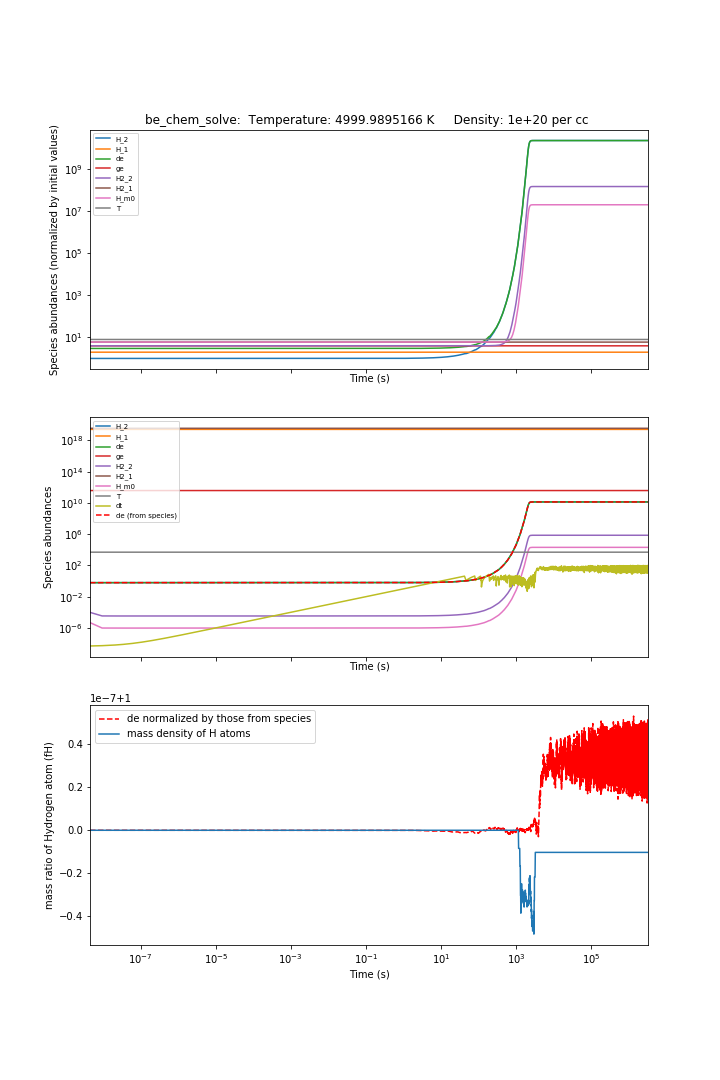

In [65]:
mask = rv_int_be_chem['successful']
t_arr = rv_int_be_chem['t'][mask]

png_name = make_plots( primordial, init, rv_int_be_chem, solver_name = 'be_chem_solve', t_min = t_arr[0], t_max = t_arr[-1]  )
print(png_name)
Image(png_name)

In [ ]:
%%time
ith_T = numpy.array([5000.0])
rho = numpy.array([1.0e20])
fH = equi_fH(rho, ith_T)

init, primordial = Init_values( ith_T , rho, fH )

primordial.write_solver("sundials_time", solver_template = "sundials_time", 
                    ode_solver_source = "cvodes_solver_time.C", 
                    output_dir = ".",
                        init_values=init,
                        input_is_number=False)

sundials_solver_run = pyximport.load_module("sundials_time_solver_run",
                            "sundials_time_solver_run.pyx",
                            build_inplace = True, pyxbuild_dir = "_dengo_temp")
rv, rv_int_sundials = sundials_solver_run.run_sundials_time(init, 1.0e12 , niter=1e4) # , dtarr = dt_arr)

In [ ]:
mask = rv_int_sundials['successful']
t_arr = rv_int_sundials['t'][mask]
png_name = make_plots( primordial, init, rv_int_sundials, solver_name = 'ttsundials', t_min = t_arr[0], t_max = t_arr[-1])
Image(png_name)



In [ ]:
mask = (rv_int_sundials['successful'])
mask[mask]


In [ ]:
plt.hist( rv_int_sundials['t'][:-1] - rv_int_sundials['t'][1:] + (rv_int_sundials['dt'][1:]) )

In [ ]:
(rv_int_sundials['dt'][mask])

In [ ]:
# RUNTIME STATISTICS

be_stat_rtime = [7.34, 7.23, 7.39, 7.97, 9.67]
sundials_stat_rtime = [6.57,6.63, 6.56,6.71, 23.3]

sundials_stat_sim_time = [1e12, 1e12, 1e12, 8.323e11, 0.136]
be_stat_sim_time = [1e12,1e12,1e12, 1.914e10, 3.3e6]
Temp_array = [1000,2000,3000,4000,5000]

In [ ]:
plt.clf()
plt.plot(Temp_array, be_stat_rtime, label='BE run time (s)')
plt.plot(Temp_array, sundials_stat_rtime, label='Sundials run time (s)')
plt.xlabel('Temperature (K) at a fixed density 1e20 per cc')
plt.ylabel('Run time (s)')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.semilogy(Temp_array, be_stat_sim_time, label='BE sim time (s)')
plt.semilogy(Temp_array, sundials_stat_sim_time, label='Sundials sim time (s)')
plt.xlabel('Temperature (K) at a fixed density 1e20 per cc')
plt.ylabel('time passed in the simulation (s)')
plt.legend()
plt.show()

In [ ]:
plt.clf()
fig, ax1 = plt.subplots()

ax1.plot(Temp_array, be_stat_rtime, label='BE run time (s)',color='r' )
ax1.plot(Temp_array, sundials_stat_rtime, label='Sundials run time (s)', color='r', ls='--')
ax1.set_xlabel('Temperature (K) at a fixed density 1e20 per cc')
ax1.set_ylabel('Wall time (s)',color='r')


ax2 = ax1.twinx()
ax2.semilogy(Temp_array, be_stat_sim_time, label='BE sim time (s)', color='b')
ax2.semilogy(Temp_array, sundials_stat_sim_time, label='Sundials sim time (s)',color='b', ls = '--')
ax2.set_xlabel('Temperature (K) at a fixed density 1e20 per cc')
ax2.set_ylabel('time passed in the simulation (s)', color='b')
ax1.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
plt.scatter(range(len(primordial.T)), primordial.T)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
len(primordial.T)

In [ ]:
primordial.T[primordial.T < 6000]

In [ ]:
eq = Integer(0)
for sp in primordial.required_species:
    try:
        
        eq = eq +( primordial.species_total(sp) )
        if sp.name == 'de':
            # eq = eq - ( primordial.species_total(sp) )
            print(eq)
        print('_____________________{}_________________'.format(sp.name))
    except:
        pass

In [ ]:
eq

In [ ]:
(primordial.required_species)

In [ ]:
i = 3
print(elements[i])
print(primordial.species_total(elements[i]))
diff( primordial.species_total(elements[i]), elements[3].name )

In [ ]:
print( primordial.print_jacobian_component(elements[i], elements[i]) )
print( primordial.print_jacobian_component(elements[3], elements[i]) )

In [ ]:
elements

In [ ]:
primordial.species_total('H_2')

In [ ]:
for i in range(23):
    try: 
        if (i+1) not in [3,4,5,6]:
            rxn = primordial.reactions['k{0:02d}'.format(i+1) 
            coeff = rxn.coeff_fn(primordial)
            T = primordial.T
            plt.loglog(T, coeff, label = 'k{0:02d}'.format(i+1) )
    except:
        pass

plt.legend()
plt.show()

In [ ]:
idx_min = find_nearest(T , 4000)
idx_max = find_nearest(T , 6000)

In [ ]:
rxn = primordial.reactions['k01']

In [ ]:
rxn.left_side

In [ ]:
plt.semilogx(rv_int_sundials['de'][0])
plt.show()

In [ ]:
for i in range(23):
    try: 
        if (i+1) not in [3,4,5,6]:
            rxn = primordial.reactions['k{0:02d}'.format(i+1) ]
            for n, sname in rxn.left_side:
                if sname.name in ["H2_2", "de", "H_m0"]:
                    print(rxn)
                    break
                for n, sname in rxn.right_side:
                    if sname.name in ["H2_2", "de", "H_m0"]:
                        print(rxn)
                        break
    except:
        pass

In [ ]:
eq = primordial.species_total('H2_2')

In [ ]:
eq -= primordial.species_total('de')

In [ ]:
eq -= primordial.species_total('H_m0')

In [ ]:
rxn_rate = []
idx_T = find_nearest(primordial.T,6000)
for i in range(23):
    try: 
        if (i+1) in [ 9, 10, 11, 17, 18, 19 ]:
            rxn = primordial.reactions['k{0:02d}'.format(i+1) ]
            for rxn.left_side
            rxn_rate.append( rxn.coeff_fn(primordial)[idx_T] *  )
    except:
        pass

In [ ]:
rxn.right_side

In [ ]:
eq = symbols("0")

In [ ]:
eq -= primordial.species_total('H_2')

In [ ]:
eq = symbols("0")

atom_no = [0,2,1,2,1,0,1]

for idx, i in enumerate(primordial.required_species):
    
    if i.name not in ["ge", "de"]:
        # print(eq)
        eq += primordial.species_total(i.name)
print(eq)

In [ ]:
eq

In [ ]:
primordial.required_species

In [82]:
sundials_solver_run = pyximport.load_module("sundials_time_solver_run",
                            "sundials_time_solver_run.pyx",
                            build_inplace = True, pyxbuild_dir = "_dengo_temp")
rv, rv_int_sundials = sundials_solver_run.run_sundials_time(init, 1.0e15 , niter=1e3) # , dtarr = dt_arr)

final iteration: 6
End in 6 iterations: 1.67396e+12 / 1.00000e+15 (9.98326e+14)


('de conserved?   ', 1.0000000000000002)
('mass conserved? ', 1.0129757425933019)


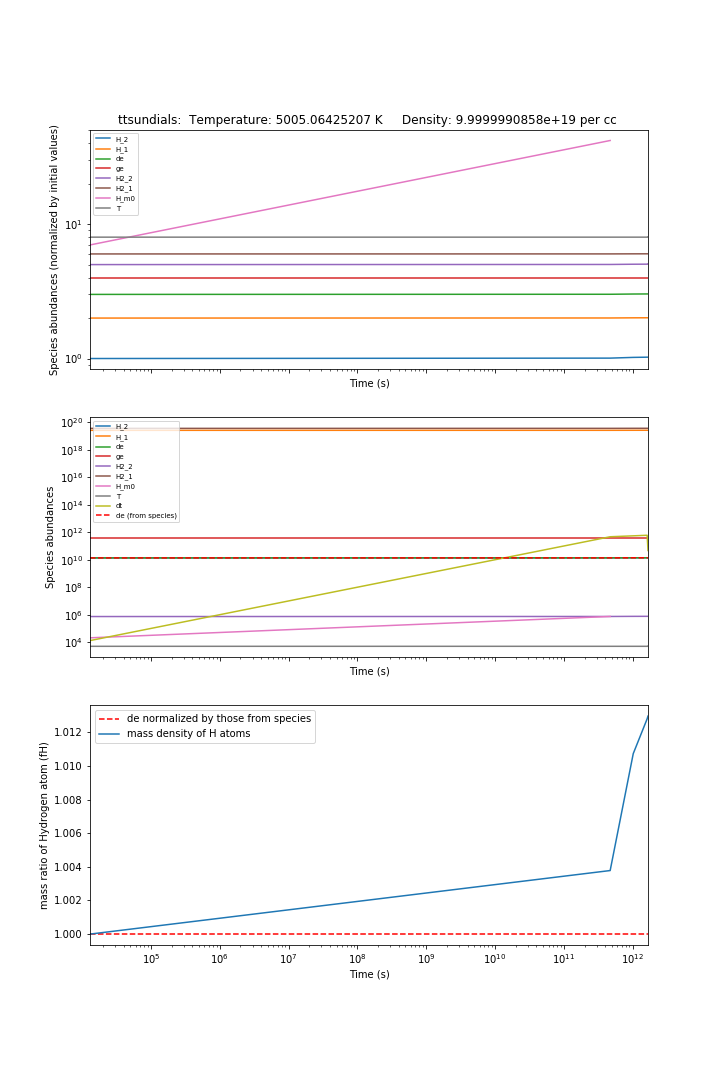

In [83]:
mask = rv_int_sundials['successful']
t_arr = rv_int_sundials['t'][mask]
png_name = make_plots( primordial, init, rv_int_sundials, solver_name = 'ttsundials', t_min = t_arr[0], t_max = t_arr[-1])
Image(png_name)

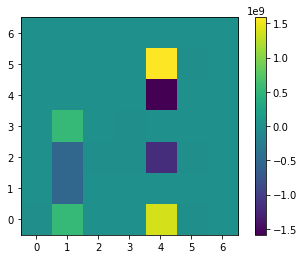

TypeError: Image data can not convert to float

In [102]:
plt.imshow( numpy.array(rv_int_sundials['Jac'] ), origin='lower')
plt.colorbar()
plt.show()


plt.imshow( (w*v) ,origin='lower')
plt.colorbar()
plt.show()

In [44]:
jacobian = rv_int_sundials['Jac']
print(jacobian)
# inv = numpy.linalg.inv(jacobian)

w, v= numpy.linalg.eig(jacobian)
namelist = numpy.array(['H2_1', 'H2_2', 'H_1', 'H_2', 'H_m0', 'de', 'ge'])

for eival, eivec in zip(w, v):
    loc = numpy.array(range(len(eivec)))

    print(numpy.sum(eivec[:4]) )
    print(eivec[ loc[numpy.abs(eivec) > 1e-6] ])
    print( namelist[ loc[numpy.abs(eivec) > 1e-6]] )
    print(eivec)
    print('*'*100)

[[  6.94506555e-310   3.75796844e-316   0.00000000e+000  -7.63277803e+283
    6.94506634e-310   6.94506623e-310   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   1.65169957e-220   6.94506635e-310]
 [  6.94505687e-310  -3.39981117e-158   6.94505687e-310   6.94498057e-310
    5.41141341e-041   6.94505687e-310   6.94498057e-310]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000  -3.67112871e-197
    6.94506634e-310   6.94498073e-310   2.99382801e+052]
 [  6.94506181e-310   6.94497990e-310   0.00000000e+000   0.00000000e+000
    0.00000000e+000   4.42201243e+096   6.94506635e-310]
 [  6.94498073e-310   1.79989302e-302   6.94505687e-310   6.94498057e-310
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  3.00806175e+144   6.94505687e-310   6.94505687e-310  -6.64080621e+188
    6.94506181e-310   6.94497990e-310   1.97626258e-321]]
(-1+0j)
[ 1.+0.j -1.+0.j -1.-0.j]
['H2_1' 'H2_2' 'H_1']
[ 1.+0.j -1.+0.j -1.-0.j  

In [65]:
1.5e-5 * -55736681627.9

-836050.2244185001

In [ ]:
 rv_int_sundials['dt']

In [ ]:
-55736743648.4*1.67e-5

In [15]:
np.matrix(jacobian)

matrix([[ -8.25665658e+06,   1.57650674e+10,   2.32885964e+07,
          -8.49350103e+05,   4.28689025e+10,  -1.99245445e+02,
           0.00000000e+00],
        [  1.46351924e-14,  -1.57650674e+10,  -2.03132396e-14,
           8.51566572e+05,   2.05794451e-10,  -6.91486779e-14,
           0.00000000e+00],
        [  1.65133132e+07,  -1.57650674e+10,  -4.65771928e+07,
           8.47133634e+05,  -3.00011004e+10,  -8.46163832e+04,
           0.00000000e+00],
        [ -1.46351924e-14,   1.57650674e+10,   2.03132398e-14,
          -8.51566572e+05,  -6.42778987e-09,   1.08077136e-02,
           0.00000000e+00],
        [  0.00000000e+00,  -6.77443131e-14,  -8.99665623e-22,
          -9.80478856e-15,  -5.57367045e+10,   8.50148633e+04,
           0.00000000e+00],
        [  0.00000000e+00,  -1.28019856e-09,   1.15815487e-21,
          -4.19997021e-13,   5.57367045e+10,  -8.50148525e+04,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.

In [16]:
import pandas as pd

In [17]:
pd.DataFrame(jacobian)

,0,1,2,3,4,5,6
0,-8.256657e+06,1.576507e+10,2.328860e+07,-8.493501e+05,4.286890e+10,-1.992454e+02,0.0
1,1.463519e-14,-1.576507e+10,-2.031324e-14,8.515666e+05,2.057945e-10,-6.914868e-14,0.0
2,1.651331e+07,-1.576507e+10,-4.657719e+07,8.471336e+05,-3.000110e+10,-8.461638e+04,0.0
3,-1.463519e-14,1.576507e+10,2.031324e-14,-8.515666e+05,-6.427790e-09,1.080771e-02,0.0
4,0.000000e+00,-6.774431e-14,-8.996656e-22,-9.804789e-15,-5.573670e+10,8.501486e+04,0.0
5,0.000000e+00,-1.280199e-09,1.158155e-21,-4.199970e-13,5.573670e+10,-8.501485e+04,0.0
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [24]:
w

array([  0.00000000e+00,  -5.48338494e+07,  -1.57659190e+10,
        -5.57367895e+10,  -2.16823574e-08,   1.08076971e-02,
         0.00000000e+00])

In [54]:
Ju = rv_int_be_chem['Ju'][: , success>0][:,-1]

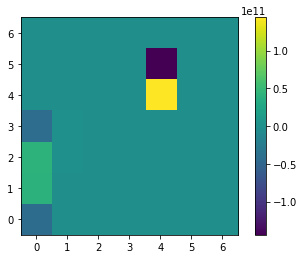

In [55]:
plt.imshow(Ju.reshape(7,7), origin='lower')
plt.colorbar()
plt.show()

In [44]:
success = rv_int_be_chem['successful']

In [60]:
rv_int_sundials['Jac']

array([[ -8.25668639e+06,   1.57650338e+10,   2.32884012e+07,
         -8.49356384e+05,   4.28688140e+10,  -1.99247300e+02,
          0.00000000e+00],
       [  1.46362952e-14,  -1.57650338e+10,  -2.03140385e-14,
          8.51572850e+05,   2.05808627e-10,  -6.91513795e-14,
          0.00000000e+00],
       [  1.65133728e+07,  -1.57650338e+10,  -4.65768024e+07,
          8.47139919e+05,  -3.00010314e+10,  -8.46162312e+04,
          0.00000000e+00],
       [ -1.46362952e-14,   1.57650338e+10,   2.03140388e-14,
         -8.51572850e+05,  -6.42823017e-09,   1.08078075e-02,
          0.00000000e+00],
       [  0.00000000e+00,  -6.77488897e-14,   1.40424864e-21,
         -9.80545095e-15,  -5.57365966e+10,   8.50147150e+04,
          0.00000000e+00],
       [  0.00000000e+00,  -1.28028610e-09,  -1.14573883e-21,
         -4.20025764e-13,   5.57365966e+10,  -8.50147042e+04,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00

In [77]:
jacobian

array([[ -8.25668639e+06,   1.57650338e+10,   2.32884012e+07,
         -8.49356384e+05,   4.28688140e+10,  -1.99247300e+02,
          0.00000000e+00],
       [  1.46362952e-14,  -1.57650338e+10,  -2.03140385e-14,
          8.51572850e+05,   2.05808627e-10,  -6.91513795e-14,
          0.00000000e+00],
       [  1.65133728e+07,  -1.57650338e+10,  -4.65768024e+07,
          8.47139919e+05,  -3.00010314e+10,  -8.46162312e+04,
          0.00000000e+00],
       [ -1.46362952e-14,   1.57650338e+10,   2.03140388e-14,
         -8.51572850e+05,  -6.42823017e-09,   1.08078075e-02,
          0.00000000e+00],
       [  0.00000000e+00,  -6.77488897e-14,   1.40424864e-21,
         -9.80545095e-15,  -5.57365966e+10,   8.50147150e+04,
          0.00000000e+00],
       [  0.00000000e+00,  -1.28028610e-09,  -1.14573883e-21,
         -4.20025764e-13,   5.57365966e+10,  -8.50147042e+04,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00

In [89]:
primordial.species_total('H_m0')

k07[i]*H_1*de - k08[i]*H_1*H_m0 - k14[i]*H_m0*de - k15[i]*H_1*H_m0 - k16[i]*H_2*H_m0 - k17[i]*H_2*H_m0 - k19[i]*H2_2*H_m0

In [70]:
primordial.reactions

{'k01': k01 : 1*H_1 + 1*de => 1*H_2 + 2*de,
 'k02': k02 : 1*H_2 + 1*de => 1*H_1,
 'k07': k07 : 1*H_1 + 1*de => 1*H_m0,
 'k08': k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de,
 'k09': k09 : 1*H_1 + 1*H_2 => 1*H2_2,
 'k10': k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2,
 'k11': k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1,
 'k12': k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de,
 'k13': k13 : 1*H2_1 + 1*H_1 => 3*H_1,
 'k14': k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de,
 'k15': k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de,
 'k16': k16 : 1*H_m0 + 1*H_2 => 2*H_1,
 'k17': k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de,
 'k18': k18 : 1*H2_2 + 1*de => 2*H_1,
 'k19': k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1,
 'k21': k21 : 2*H_1 + 1*H2_1 => 2*H2_1,
 'k22': k22 : 2*H_1 + 1*H_1 => 1*H2_1 + 1*H_1,
 'k23': k23 : 1*H2_1 + 1*H2_1 => 2*H_1 + 1*H2_1}

In [79]:
jacobian

array([[  6.90848516e-310,   3.11494240e-316,  -9.22450604e-003,
         -2.10415055e-016,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000],
       [  1.08140329e-006,   1.41443966e+018,  -7.05255340e-027,
         -5.59342438e-008,   1.16365831e-022,   3.83183122e-024,
         -0.00000000e+000],
       [  1.21953084e+015,   1.04587766e+007,   1.18615951e+007,
         -2.60641360e-009,   1.70093323e-007,  -1.18194792e-006,
          0.00000000e+000],
       [  1.08140329e-006,  -1.41443966e+018,   4.25201635e+002,
          1.03090016e+000,  -7.01561238e-005,   2.94285857e-002,
         -0.00000000e+000],
       [  5.00851151e-005,  -2.81479156e+002,   4.12574378e+018,
          1.07533947e+010,  -7.01760714e+011,  -1.47299300e-002,
         -0.00000000e+000],
       [  6.77641780e-005,   9.87030225e+001,  -4.12574378e+018,
         -1.07533947e+010,   7.01760714e+011,   1.00025558e+000,
          0.00000000e+000],
       [ -0.00000000e+000,   0.00000000e+000,   0.00

In [86]:
primordial.required_species

flag = rv_int_be_chem['successful']

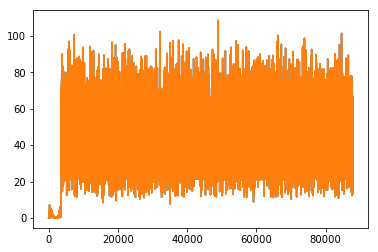

In [89]:
plt.plot(rv_int_be_chem['dt'][flag])
plt.show()